In [1]:
import numpy as np
import pandas as pd
import cPickle as pkl
from matplotlib import pyplot as plt
import time

import theano_time_corex

Using cuDNN version 6021 on context None
Mapped name None to device cuda0: GeForce GTX 980 (0000:01:00.0)


# Test run

In [2]:
with open('../data/EOD_week.pkl', 'rb') as f:
        df = pd.DataFrame(pkl.load(f))
print("Data.shape = {}".format(df.shape))

Data.shape = (887, 5038)


In [14]:
starts = [0, 5, 10]
ends = [x + 10 for x in starts]
X = [df[s:e] for (s, e) in zip(starts, ends)]

corex = theano_time_corex.TimeCorexW(nt=len(starts),
                                    nv=df.shape[1],
                                    n_hidden=3,
                                    max_iter=300,
                                    verbose=True,
                                    l2=30)
corex.fit(X)

Linear CorEx with 3 latent factors
tc = 374.236903829, obj = -6176.44972691, reg = 369.191353115, eps = 0.6
tc = 1112.3127883, obj = -6788.49773261, reg = 378.826870503, eps = 0.6
tc = 1267.3943515, obj = -6978.8689113, reg = 381.43847134, eps = 0.6
tc = 1352.77498024, obj = -6947.30118636, reg = 371.687359362, eps = 0.6
tc = 1397.87520956, obj = -6965.65134132, reg = 353.12176108, eps = 0.6
tc = 1418.38431414, obj = -7020.84113576, reg = 330.723769185, eps = 0.6
tc = 1441.14042213, obj = -7139.75324894, reg = 304.87226865, eps = 0.6
tc = 1449.93637072, obj = -7127.88976756, reg = 278.195255869, eps = 0.6
tc = 1461.17971501, obj = -7186.52541387, reg = 253.808650096, eps = 0.6
tc = 1465.52462028, obj = -7303.43783054, reg = 230.16332484, eps = 0.6
tc = 1479.17865689, obj = -7267.26123924, reg = 210.294731578, eps = 0.6
tc = 1484.87002434, obj = -7293.35722899, reg = 192.713856468, eps = 0.6
tc = 1486.7094016, obj = -7371.17534656, reg = 175.968968644, eps = 0.6
tc = 1494.79690668, obj 

tc = 2782.69171223, obj = -17869.1676043, reg = 14.0877199287, eps = 0.1296
tc = 2783.34472375, obj = -17870.2564405, reg = 13.9331741006, eps = 0.1296
tc = 2785.22608861, obj = -17853.9697755, reg = 13.5144331767, eps = 0.1296
tc = 2772.99455466, obj = -17828.9780146, reg = 13.8975967833, eps = 0.1296
tc = 2780.81934943, obj = -17903.9501019, reg = 13.84256252, eps = 0.1296
tc = 2777.82330482, obj = -17872.4604409, reg = 13.0930894766, eps = 0.1296
tc = 2783.10883199, obj = -17823.7770765, reg = 13.9657444485, eps = 0.1296
tc = 2783.68742665, obj = -17830.4716639, reg = 13.7477279279, eps = 0.1296
tc = 2781.63783951, obj = -17842.8639023, reg = 13.9830146907, eps = 0.1296
tc = 2786.18636983, obj = -17790.4849893, reg = 13.3271293821, eps = 0.1296
Annealing iteration finished, time = 4.732858181
tc = 2835.88885987, obj = -21207.3169483, reg = 12.3408133265, eps = 0.07776
tc = 2831.48100221, obj = -21226.8284083, reg = 12.0674272661, eps = 0.07776
tc = 2833.04302978, obj = -21190.046031

In [4]:
print corex.tc
print sum(corex.tc)

[2639.7599291206548, 2624.9433354998923, 2615.0586807184754]
7879.76194534


# Replicate the experiment from time-varying GLASSO

## Regularizatin on Ws

In [16]:
with open('../data/EOD_day.pkl', 'rb') as f:
    day_df = pd.DataFrame(pkl.load(f))

print("Data.shape = {}".format(day_df.shape))

df_2010 = day_df[day_df.index >= '2010-01-01']
df_2010 = df_2010[df_2010.index <= '2012-01-01']  # NOTE: 2 years
df_2010 = df_2010[['AAPL', 'MSFT', 'AMZN', 'INTC', 'BA', 'FDX']]
df_2010 = df_2010.loc[:, list(np.max(np.array(df_2010), axis=0)<1)]

X = []
for i in range(1, 365//7 - 2):
    week_start = 5 * i
    week_end = 5 * (i + 1)
    X.append(df_2010[week_start : week_end])  # two weeks
print [len(x) for x in X]

Data.shape = (4277, 5038)
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


In [17]:
corex_2010 = theano_time_corex.TimeCorexW(nt=len(X),
                                         nv=df_2010.shape[1],
                                         n_hidden=3,
                                         max_iter=300,
                                         l2=1,
                                         verbose=True)
corex_2010.fit(X)

Linear CorEx with 3 latent factors
tc = 9.76628894567, obj = 138.288358451, reg = 259.25605982, eps = 0.6
tc = 9.99908001353, obj = 124.151810874, reg = 247.734934735, eps = 0.6
tc = 10.2058757396, obj = 130.985372813, reg = 236.74574431, eps = 0.6
tc = 10.375754327, obj = 87.4711637508, reg = 226.219277295, eps = 0.6
tc = 10.5220352616, obj = 81.3156218499, reg = 216.255082106, eps = 0.6
tc = 10.6746464739, obj = 84.1204201655, reg = 206.736630734, eps = 0.6
tc = 10.8333610603, obj = 87.7024574013, reg = 197.636439929, eps = 0.6
tc = 10.9836152837, obj = 46.1227987928, reg = 188.971058533, eps = 0.6
tc = 11.1224724928, obj = 50.7928166028, reg = 180.741665555, eps = 0.6
tc = 11.2536825098, obj = 40.6286184833, reg = 172.903466472, eps = 0.6
tc = 11.341037627, obj = 31.2292357568, reg = 165.374165005, eps = 0.6
tc = 11.4148660246, obj = 29.3611513909, reg = 158.230192098, eps = 0.6
tc = 11.4837128215, obj = 17.7697310068, reg = 151.40951237, eps = 0.6
tc = 11.5531736752, obj = 15.70331

tc = 57.886670934, obj = -159.229156542, reg = 12.1558880581, eps = 0.1296
tc = 58.1406897406, obj = -162.898944228, reg = 12.0478662864, eps = 0.1296
tc = 58.3922552633, obj = -141.000325835, reg = 11.9273055465, eps = 0.1296
tc = 58.6727415177, obj = -153.979847483, reg = 11.8317460757, eps = 0.1296
tc = 58.9596589855, obj = -139.509044216, reg = 11.7621595787, eps = 0.1296
tc = 59.1976481651, obj = -158.747001832, reg = 11.6691952887, eps = 0.1296
tc = 59.3968046689, obj = -158.53407891, reg = 11.554508524, eps = 0.1296
tc = 59.6065760625, obj = -159.593961266, reg = 11.4616438328, eps = 0.1296
tc = 59.8072101372, obj = -152.950964917, reg = 11.3501892829, eps = 0.1296
tc = 60.0305112698, obj = -155.276539453, reg = 11.2407850214, eps = 0.1296
tc = 60.2781608999, obj = -151.034762683, reg = 11.1439093459, eps = 0.1296
Annealing iteration finished, time = 10.4985649586
tc = 62.1486659339, obj = -155.226273043, reg = 11.0609041334, eps = 0.07776
tc = 62.4121945755, obj = -163.24245945

In [18]:
W = [w.get_value() for w in corex_2010.ws]

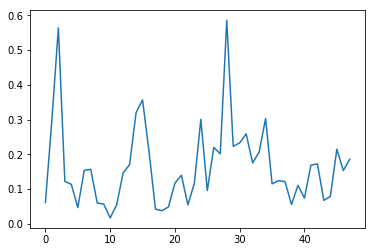

In [19]:
diff = [np.square(W[t+1] - W[t]).sum() for t in range(len(W) - 1)]
plt.plot(diff)
plt.show()

In [20]:
covs = corex_2010.get_covariance()
covs_diff = [np.square(covs[t+1] - covs[t]).sum() for t in range(len(W) - 1)]

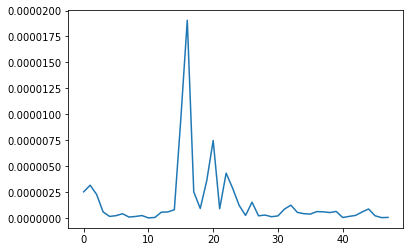

In [21]:
plt.plot(covs_diff)
plt.show()

In [22]:
stocks = ['AAPL', 'MSFT', 'AMZN', 'INTC', 'BA', 'FDX']
indices = [list(df_2010.columns).index(x) for x in stocks]

In [23]:
print np.array(corex_2010.mis).argmax(axis=1)[:, indices]

[[2 2 2 2 2 1]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 2 2 0 2 2]
 [0 0 2 0 2 2]
 [2 2 2 1 0 2]
 [1 2 2 1 2 0]
 [1 2 2 1 2 1]
 [2 2 2 2 2 2]
 [2 0 2 2 2 2]
 [2 2 2 2 2 2]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 1]
 [0 0 0 0 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]
 [0 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 2 1 1 1]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 1 0 1]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [0 2 0 0 0 2]
 [2 2 1 2 2 2]
 [2 1 1 2 2 2]
 [2 0 2 2 2 2]
 [2 2 2 2 2 1]
 [2 2 2 1 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 1 1 0 1 1]
 [0 1 0 0 0 1]
 [1 1 0 1 1 1]]


### apple MI with hidden factors over the time

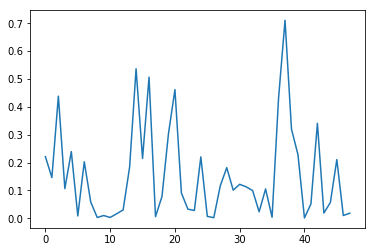

In [24]:
apple = indices[0]
mis = np.array(corex_2010.mis)[:, :, apple]
mis_diff = [np.square(mis[t+1] - mis[t]).sum() for t in range(len(X)-1)]

plt.plot(mis_diff)
plt.show()

## Regularizatin on Global MIs

In [25]:
corex_2010_mi = theano_time_corex.TimeCorexGlobalMI(nt=len(X),
                                         nv=df_2010.shape[1],
                                         n_hidden=3,
                                         max_iter=300,
                                         l2=0.1,
                                         verbose=True)
corex_2010_mi.fit(X)

Linear CorEx with 3 latent factors
tc = 11.5685098575, obj = 126.948029819, reg = 252.183902234, eps = 0.6
tc = 11.7985990818, obj = 133.920557518, reg = 258.840992286, eps = 0.6
tc = 11.9732201182, obj = 130.303539085, reg = 256.515670764, eps = 0.6
tc = 12.0867166828, obj = 75.5709342785, reg = 206.540886383, eps = 0.6
tc = 12.2003295536, obj = 89.3960358588, reg = 232.011160669, eps = 0.6
tc = 12.3432829397, obj = 167.95283691, reg = 289.248896217, eps = 0.6
tc = 12.4742790796, obj = 88.7846668355, reg = 218.838778081, eps = 0.6
tc = 12.5560099954, obj = 162.506928492, reg = 278.728085705, eps = 0.6
tc = 12.6046330371, obj = 102.373418234, reg = 218.691882557, eps = 0.6
tc = 12.6777683156, obj = 122.2507548, reg = 254.264415246, eps = 0.6
tc = 12.7227130379, obj = 93.9738479565, reg = 212.150041064, eps = 0.6
tc = 12.8124734062, obj = 77.3470698366, reg = 203.718799562, eps = 0.6
tc = 12.9126216635, obj = 107.170625541, reg = 223.127078408, eps = 0.6
tc = 12.9744731396, obj = 137.10

tc = 52.6399322837, obj = -90.6901173235, reg = 51.3612964495, eps = 0.1296
tc = 52.71669489, obj = -116.89594289, reg = 43.2419407799, eps = 0.1296
tc = 52.804377961, obj = -92.0951206262, reg = 43.910038892, eps = 0.1296
tc = 52.9082070875, obj = -82.5412431503, reg = 57.9811793996, eps = 0.1296
tc = 53.0155070395, obj = -93.2838751074, reg = 63.5780779677, eps = 0.1296
tc = 53.1211670778, obj = -67.0601377088, reg = 77.1027385979, eps = 0.1296
tc = 53.2195845939, obj = -69.8224747581, reg = 72.0918658554, eps = 0.1296
tc = 53.3410403812, obj = -78.3355742614, reg = 66.0012833391, eps = 0.1296
tc = 53.4722824905, obj = -101.932722805, reg = 45.9764113276, eps = 0.1296
tc = 53.5866152371, obj = -104.25218115, reg = 35.414130847, eps = 0.1296
tc = 53.7085418171, obj = -51.6791486474, reg = 94.7442334748, eps = 0.1296
Annealing iteration finished, time = 10.522454977
tc = 55.5260359446, obj = -115.004429064, reg = 37.4707690699, eps = 0.07776
tc = 55.6161836442, obj = -126.433771007, re

In [26]:
W = [w.get_value() for w in corex_2010_mi.ws]

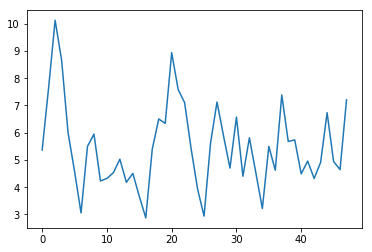

In [27]:
diff = [np.square(W[t+1] - W[t]).sum() for t in range(len(W) - 1)]
plt.plot(diff)
plt.show()

In [28]:
covs = corex_2010_mi.get_covariance()
covs_diff = [np.square(covs[t+2] - covs[t]).sum() for t in range(len(W) - 2)]

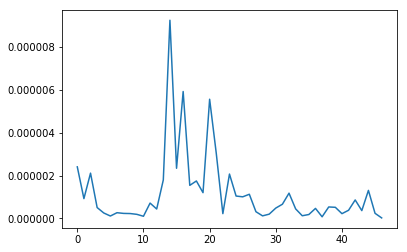

In [29]:
plt.plot(covs_diff)
plt.show()

In [30]:
print np.array(corex_2010_mi.mis).argmax(axis=1)[:, indices]

[[0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 0 1 0 2 1]
 [2 2 1 2 0 2]
 [1 0 1 1 0 1]
 [0 0 0 0 0 0]
 [2 2 2 2 2 2]
 [1 0 2 1 1 1]
 [1 1 1 2 1 0]
 [2 0 1 2 1 0]
 [2 2 2 1 1 1]
 [0 1 2 0 1 1]
 [1 1 2 1 2 1]
 [1 0 1 2 1 2]
 [0 0 0 0 0 2]
 [1 1 1 1 1 1]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 2 2 2]
 [0 0 0 0 0 0]
 [2 2 2 2 2 0]
 [1 2 2 2 2 0]
 [0 0 0 0 2 2]
 [2 2 2 2 2 2]
 [2 2 0 2 0 0]
 [2 2 2 2 2 2]
 [0 2 2 2 2 2]
 [2 1 2 2 0 1]
 [1 1 0 1 1 0]
 [2 0 2 0 2 2]
 [0 0 0 0 0 0]
 [0 2 0 0 0 0]
 [1 1 1 1 1 1]
 [2 2 2 2 2 2]
 [0 0 0 2 0 2]
 [0 0 0 0 0 0]
 [2 1 1 1 1 2]
 [0 0 0 0 0 0]
 [2 0 2 2 2 2]
 [0 0 0 2 2 0]
 [2 2 0 2 0 0]
 [0 1 0 2 2 2]
 [1 1 0 1 2 2]
 [2 2 2 0 2 2]
 [1 2 1 1 1 2]
 [1 2 1 1 1 2]
 [1 0 0 1 0 0]
 [2 2 0 0 0 2]
 [2 2 1 0 2 2]]


## apple MI with hidden factors over the time

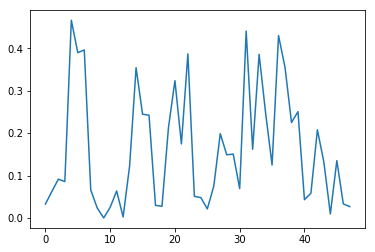

In [31]:
apple = indices[0]
mis = np.array(corex_2010_mi.mis)[:, :, apple]
mis_diff = [np.square(mis[t+1] - mis[t]).sum() for t in range(len(X)-1)]

plt.plot(mis_diff)
plt.show()

# TODOS 
1. compare single vs reg in sense of sum(TC)
2. understand why covariance difference is exactly the same for single and regularized models